In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
#from IPython.display import Image
#from IPython.display import clear_output
import time
import requests
import json
from datetime import timedelta
#import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
#import altair as alt
#alt.data_transformers.disable_max_rows()

In [2]:
#from community import community_louvain
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
'''from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir'''

"from os import listdir\nfrom os.path import isfile, join\n\nclass FilePathManager:\n    def __init__(self, local_dir: str):\n        self.local_dir = local_dir\n    \n    def retrieve_full_path(self):\n        return os.getcwd()+'/'+self.local_dir"

In [4]:
from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'\\'+self.local_dir

In [5]:
class Loader:
    df = pd.DataFrame()
    
    def load_data(self, file_name):
        pass
    
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)

In [6]:
from typing import Callable
 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path(), low_memory=False)
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [7]:
def clean_data(df):
    df['Datetime_updated'] = pd.to_datetime(df['Datetime_updated'], infer_datetime_format=True)
    df['Datetime_updated_seconds'] = pd.to_datetime(df['Datetime_updated_seconds'], infer_datetime_format=True)
    return df

In [8]:
loader = CSVLoader(FilePathManager('EDA\\Data_API.csv.gz'))
loader.load_data(clean_data)
df = loader.get_df()

In [9]:
gb = df.groupby('Collection')    

In [10]:
print( "total # of unique collections in dataset:", len(gb.groups.keys()) )

total # of unique collections in dataset: 6283


In [11]:
# get target variable labels
f = open('EDA\\atomichub.config')
data = json.load(f)
blist = data.get('data').get('global').get('col.blist')
wlist = data.get('data').get('global').get('col.wlist')

In [12]:
print("# blacklisted collections on AtomicHub:", len(blist))
print("# whitelisted collections on AtomicHub:", len(wlist))

# blacklisted collections on AtomicHub: 5941
# whitelisted collections on AtomicHub: 2352


In [13]:
# match target variable labels with collection names in dataset
blacklist = []
whitelist = []
neither = []
for c in gb.groups.keys():
    blacklisted = True if c in blist else False
    whitelisted = True if c in wlist else False
    if blacklisted:
        blacklist.append(1)
    else:
        blacklist.append(0)
    if whitelisted:
        whitelist.append(1)
    else:
        whitelist.append(0)
    if not blacklisted and not whitelisted:
        neither.append(1)
    else:
        neither.append(0)

In [14]:
coll_labels = pd.DataFrame({'collection':gb.groups.keys(),'blacklist':blacklist, 'whitelist':whitelist, 'neither':neither})
coll_labels

,collection,blacklist,whitelist,neither
0,0-domains,0,0,1
1,0x-meets-imtoken,0,0,1
2,0x001ba7dc2ddfa893c17b6b478c9853b83fc8594c,0,0,1
3,0xbitcoinmemes,0,0,1
4,0xearth,0,0,1
...,...,...,...,...
6278,zodiacstars1,0,0,1
6279,zombaeseries,0,1,0
6280,zombieartist,0,1,0
6281,zombiesperks,0,0,1


In [15]:
print('blacklisted collections in dataset:', sum(coll_labels['blacklist']), ",", 
      round(sum(coll_labels['blacklist'])/coll_labels.shape[0]*100,1),'%')
print('\nwhitelisted collections in dataset:', sum(coll_labels['whitelist']), ",",
      round(sum(coll_labels['whitelist'])/coll_labels.shape[0]*100,1),'%')
print('\ncollections not white or black listed in dataset:', sum(coll_labels['neither']), ",", 
      round(sum(coll_labels['neither'])/coll_labels.shape[0]*100,1),'%')

blacklisted collections in dataset: 275 , 4.4 %

whitelisted collections in dataset: 720 , 11.5 %

collections not white or black listed in dataset: 5288 , 84.2 %


In [16]:
# Collections for model training 
coll_train = coll_labels[coll_labels['neither']==0]
coll_train

,collection,blacklist,whitelist,neither
31,12345rainbow,1,0,0
40,1amazingbook,0,1,0
43,1bitcoinlive,0,1,0
46,1bodyinmove1,0,1,0
50,1coolartnft1,0,1,0
...,...,...,...,...
6272,zeugencorona,1,0,0
6274,zippergirls1,0,1,0
6275,zlfhomedecor,0,1,0
6279,zombaeseries,0,1,0


In [17]:
# Collections with the most transactions
gb_count = gb['Collection'].count()
gb_count.sort_values(ascending=False).head(15)

Collection
alien.worlds      1288810
Cryptokitties     1092177
Gods-unchained     383965
stf.capcom         318737
kogsofficial       300854
Sorare             290485
mlb.topps          249151
Godsunchained      236210
Axie               171273
Rarible            132928
officialhero       117653
gpk.topps           68402
cartombs.r2         64986
0xuniverse          48714
upland.cards        47026
Name: Collection, dtype: int64

In [18]:
# create a list of dataframes for all collections that are whitelisted or blacklisted
collection_dfs = [(x, gb.get_group(x)) for x in coll_train['collection']]

In [19]:
collection_dfs[100][1]

,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,...,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category
3137139,atomicassets,1.099524e+12,NaN,sg54o.wam,NaN,enmbe.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 22:03:14,NaN,"('allenvvorlds', '1099523870996')",All,Other
3137154,atomicassets,1.099524e+12,NaN,sg54o.wam,NaN,t4mra.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 22:02:58,NaN,"('allenvvorlds', '1099523870997')",All,Other
3137224,atomicassets,1.099524e+12,NaN,sg54o.wam,NaN,gd5ri.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 22:01:42,NaN,"('allenvvorlds', '1099523870998')",All,Other
3139677,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,tsqra.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 21:07:15,NaN,"('allenvvorlds', '1099523870989')",All,Other
3139774,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,t4mra.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 21:04:15,NaN,"('allenvvorlds', '1099523870993')",All,Other
3139941,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,t4mra.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 20:59:59,NaN,"('allenvvorlds', '1099523870995')",All,Other
3139977,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,sg54o.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 20:59:04,NaN,"('allenvvorlds', '1099523870996')",All,Other
3140033,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,sg54o.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 20:58:04,NaN,"('allenvvorlds', '1099523870997')",All,Other
3140069,atomicassets,1.099524e+12,NaN,aw4bi.wam,NaN,sg54o.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 20:57:09,NaN,"('allenvvorlds', '1099523870998')",All,Other
3141036,atomicassets,1.099524e+12,NaN,oqena.wam,NaN,2rbra.wam,NaN,QmaaYjo6Nq48mZfmy53ZVqcvxZHXWUPjpduAKzQvf3gu27,https://ipfs.io/ipfs/QmaaYjo6Nq48mZfmy53ZVqcvx...,https://ipfs.atomichub.io/ipfs/QmaaYjo6Nq48mZf...,...,NaN,NaN,allenvvorlds,Atomic,2021-04-14,2021-04-14 20:35:32,NaN,"('allenvvorlds', '1099523817788')",All,Other


In [20]:
print("total # of black/whitelisted collections in dataset:", len(collection_dfs))
print("total # of blacklisted collections in dataset:", sum(coll_train['blacklist']))
print("total # of whitelisted collections in dataset:", sum(coll_train['whitelist']))

total # of black/whitelisted collections in dataset: 995
total # of blacklisted collections in dataset: 275
total # of whitelisted collections in dataset: 720


In [21]:
def datetime_index(collection):
    dt_collection = collection.reset_index(drop=True)
    dt_collection.loc[dt_collection[['Datetime_updated_seconds']].duplicated(),'Datetime_updated_seconds']= \
    dt_collection[dt_collection[['Datetime_updated_seconds']].duplicated()]['Datetime_updated_seconds'].\
    map(lambda x: x + pd.to_timedelta(1, unit='s'), na_action=None)
    
    dt_collection = dt_collection[['Datetime_updated_seconds','Seller_address','Buyer_address',
                                   'Price_USD','Price_Crypto']].\
    set_index('Datetime_updated_seconds').sort_values(by='Datetime_updated_seconds', ascending=True)
       
    return dt_collection

In [22]:
def get_graph(collection_df):
    G = nx.Graph()
    node_set = set()
    density_array = []
    vertex_count = []
    edge_count = []
    max_diameter = []
    max_radius = []
    max_periphery = []
    for idx, row in collection_df.iterrows():
        buyer_address = row['Buyer_address']
        seller_address = row['Seller_address']
        if buyer_address not in node_set:
            node_set.add(buyer_address)
            G.add_node(buyer_address)
        if seller_address not in node_set:
            node_set.add(seller_address)
            G.add_node(buyer_address)
        G.add_edge(buyer_address, seller_address)
        density_array.append(nx.density(G))
        vertex_count.append(G.number_of_nodes())
        edge_count.append(G.number_of_edges())
        '''if nx.is_connected(G):
            max_diameter.append(nx.diameter(G))
            max_radius.append(nx.max_radius(G))
            max_periphery.append(len(nx.periphery(G)))
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            larget_graph = G.subgraph(largest_cc).copy()
            max_radius.append(nx.radius(larget_graph))
            max_diameter.append(nx.diameter(larget_graph))
            max_periphery.append(len(nx.periphery(larget_graph)))'''
    return density_array, vertex_count, edge_count, #max_radius, max_diameter, max_periphery 

In [23]:
network_ntrades = None
ntrades = 3000

for collection in collection_dfs:
       
    name = str(collection[0])
    a_collection = None
    a_collection = datetime_index(collection[1])
    if a_collection.shape[0] > ntrades:
         a_collection = a_collection[0:ntrades]
    
    densities, vertex_count, edge_count = get_graph(a_collection) #, radius, diameter, periphery
    a_collection['densities']= densities
    a_collection['vertex_count']= vertex_count
    a_collection['edge_count']= edge_count
    a_collection['collection']= name
    #collection[1]['radius']= radius
    #collection[1]['diameter']= diameter
    #collection[1]['periphery']= periphery
            
    if a_collection is not None:
        if network_ntrades is not None:
            network_ntrades = pd.concat([network_ntrades, a_collection])
        else:
            network_ntrades = a_collection

In [24]:
#path = 'C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\network_3000.csv'
#network_ntrades.to_csv(path)
#pd.read_csv(path)

In [25]:
#loader = CSVLoader(FilePathManager('network_2000.csv'))
#loader.load_data()
#network_2000 = loader.get_df()

In [26]:
network_ntrades

,Seller_address,Buyer_address,Price_USD,Price_Crypto,densities,vertex_count,edge_count,collection
Datetime_updated_seconds,,,,,,,,
2020-12-02 12:28:01,mejaw.wam,yulaw.wam,0.040150,1.000,1.000000,2,1,12345rainbow
2020-12-04 20:02:10,dl3qw.wam,p1cqw.wam,0.036259,0.990,0.333333,4,2,12345rainbow
2021-03-31 09:37:38,ysir2.wam,5fnay.wam,0.261350,1.000,1.000000,2,1,1amazingbook
2021-03-31 09:38:25,ysir2.wam,5h1b4.wam,0.001530,0.005,0.666667,3,2,1amazingbook
2021-04-01 02:00:19,ysir2.wam,5fnay.wam,0.261350,1.000,0.666667,3,2,1amazingbook
...,...,...,...,...,...,...,...,...
2021-03-09 16:27:13,2v.aw.wam,25.aw.wam,0.286800,1.000,0.047619,43,43,zombieartist
2021-03-10 10:14:26,xgyaw.wam,jdvb2.wam,3.855500,22.000,0.047619,43,43,zombieartist
2021-03-15 03:07:42,xgyaw.wam,hehb.wam,1.287500,5.000,0.046512,44,44,zombieartist


In [27]:
# Correctly Truncated alien.worlds to first 3000 rows
network_ntrades[network_ntrades['collection']=='alien.worlds']

,Seller_address,Buyer_address,Price_USD,Price_Crypto,densities,vertex_count,edge_count,collection
Datetime_updated_seconds,,,,,,,,
2020-08-27 14:26:50,ckq.i.wam,2mtaq.wam,30.609000,600.0,1.000000,2,1,alien.worlds
2020-08-27 14:49:39,p35qu.wam,2mtaq.wam,25.405470,498.0,0.666667,3,2,alien.worlds
2020-08-27 14:58:48,tnlau.wam,2mtaq.wam,15.253485,299.0,0.500000,4,3,alien.worlds
2020-08-27 15:41:08,guzdsobwg4ge,ubhqu.wam,10.151985,199.0,0.266667,6,4,alien.worlds
2020-08-27 16:00:10,3f312.wam,djhqu.wam,20.354985,399.0,0.178571,8,5,alien.worlds
...,...,...,...,...,...,...,...,...
2020-10-15 19:53:59,djhqu.wam,kreau.wam,0.382300,10.0,0.020588,322,1064,alien.worlds
2020-10-15 19:54:05,djhqu.wam,nfuau.wam,0.382300,10.0,0.020588,322,1064,alien.worlds
2020-10-15 19:54:11,djhqu.wam,nfuau.wam,0.382300,10.0,0.020588,322,1064,alien.worlds


In [28]:
network_ntrades_gb = network_ntrades.groupby('collection')
network_ntrades_dfs = [(x, network_ntrades_gb.get_group(x)) for x in network_ntrades_gb.groups.keys()]

In [29]:
network_ntrades_dfs[100][1]

,Seller_address,Buyer_address,Price_USD,Price_Crypto,densities,vertex_count,edge_count,collection
Datetime_updated_seconds,,,,,,,,
2021-04-14 14:51:10,aw4bi.wam,jkorg.wam,7.257000,30.000000,1.000000,2,1,allenvvorlds
2021-04-14 14:58:23,aw4bi.wam,ixfbg.wam,7.257000,30.000000,0.666667,3,2,allenvvorlds
2021-04-14 14:59:04,aw4bi.wam,ixfbg.wam,7.257000,30.000000,0.666667,3,2,allenvvorlds
2021-04-14 14:59:37,aw4bi.wam,gigbg.wam,7.257000,30.000000,0.500000,4,3,allenvvorlds
2021-04-14 15:00:23,aw4bi.wam,pkzre.wam,6.773200,28.000000,0.400000,5,4,allenvvorlds
2021-04-14 15:09:45,vzubc.wam,zgjbi.wam,8.466500,35.000000,0.238095,7,5,allenvvorlds
2021-04-14 15:14:03,aw4bi.wam,ixfbg.wam,7.015100,29.000000,0.238095,7,5,allenvvorlds
2021-04-14 15:14:37,pkzre.wam,evirg.wam,6.773200,28.000000,0.214286,8,6,allenvvorlds
2021-04-14 15:15:30,aw4bi.wam,zsere.wam,7.015100,29.000000,0.194444,9,7,allenvvorlds


## Convert to Time Series

In [30]:
def convert_to_ts(collection, time_range):
    #ts_collection = collection.reset_index()
    #ts_collection.loc[ts_collection[['Datetime_updated_seconds']].duplicated(),'Datetime_updated_seconds']= \
    #ts_collection[ts_collection[['Datetime_updated_seconds']].duplicated()]['Datetime_updated_seconds'].\
    #map(lambda x: x + pd.to_timedelta(1, unit='s'), na_action=None)
    
    ts_collection = collection.copy()
    ts_collection = ts_collection.reset_index()
    ts_collection['Datetime_updated_seconds'] = pd.to_datetime(ts_collection['Datetime_updated_seconds'], 
                                                               infer_datetime_format=True)
    volume = ts_collection.set_index('Datetime_updated_seconds')
    volume =volume.resample(time_range).agg({"Price_USD":'size'})   
    
    # mean fill for prices
    ts_collection1 = ts_collection[['Datetime_updated_seconds','Price_USD','Price_Crypto']].\
    set_index('Datetime_updated_seconds').resample(time_range).mean().ffill()
    
    # min fill for densities
    ts_collection1['densities'] = ts_collection[['Datetime_updated_seconds','densities']].\
    set_index('Datetime_updated_seconds').resample(time_range).min().ffill()
    
    # max fill for vertex & edge counts
    ts_collection1[['vertex_count', 'edge_count']] = ts_collection[['Datetime_updated_seconds','vertex_count', 'edge_count']].\
    set_index('Datetime_updated_seconds').resample(time_range).max().ffill()
    
    # no fill for volume
    ts_collection1['volume'] = volume['Price_USD']
    
    t_index = pd.DatetimeIndex(pd.date_range(start=ts_collection1.index[0], 
                                             end=ts_collection1.index[-1] + timedelta(days=1), freq=time_range))

    ts_collection1 = ts_collection1.reindex(t_index)
    ts_collection1[['Price_USD','Price_Crypto','densities', 'vertex_count', 'edge_count']] = \
    ts_collection1[['Price_USD','Price_Crypto','densities', 'vertex_count', 'edge_count']].ffill()
   
    ts_collection1 = ts_collection1.fillna(0)
    
    return ts_collection1

In [31]:
full_dataset_1day = None
for collection in network_ntrades_dfs:
    name = str(collection[0])
    collection_values = coll_train.loc[coll_train['collection']==name][['blacklist', 'whitelist']].values
    a_ts_collection = None
    if collection_values[0][0] == 1:
        a_ts_collection = convert_to_ts(collection[1], '1d')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '1'
        a_ts_collection['whitelisted'] = '0'
    if collection_values[0][1] == 1:
        a_ts_collection = convert_to_ts(collection[1], '1d')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '0'
        a_ts_collection['whitelisted'] = '1'

    if a_ts_collection is not None:
        if full_dataset_1day is not None:
            full_dataset_1day = pd.concat([full_dataset_1day, a_ts_collection])
        else:
            full_dataset_1day = a_ts_collection

In [32]:
full_dataset_1day.head(10)

,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,collection,blacklisted,whitelisted
2020-12-02,0.040150,1.000000,1.000000,2.0,1.0,1.0,12345rainbow,1,0
2020-12-03,0.040150,1.000000,1.000000,2.0,1.0,0.0,12345rainbow,1,0
2020-12-04,0.036259,0.990000,0.333333,4.0,2.0,1.0,12345rainbow,1,0
2020-12-05,0.036259,0.990000,0.333333,4.0,2.0,0.0,12345rainbow,1,0
2021-03-31,0.131440,0.502500,0.666667,3.0,2.0,2.0,1amazingbook,0,1
2021-04-01,0.261350,1.000000,0.666667,3.0,2.0,1.0,1amazingbook,0,1
2021-04-02,0.846650,3.500000,0.500000,4.0,3.0,1.0,1amazingbook,0,1
2021-04-03,0.175886,0.712000,0.285714,7.0,6.0,5.0,1amazingbook,0,1
2021-04-04,0.186912,0.990000,0.194444,9.0,7.0,1.0,1amazingbook,0,1
2021-04-05,0.201489,0.811111,0.131868,14.0,12.0,9.0,1amazingbook,0,1


In [33]:
trading_days = pd.DataFrame(full_dataset_1day['collection'].value_counts())
trading_days.columns = ['days']
trading_days = trading_days-1
trading_days

,days
anyo.b1,302
dopestickers,299
badges.b1,299
krwingerarts,298
zanygumballs,292
...,...
alonworldscs,1
muttanttssr2,1
mutantsssr2g,1
mrtreefanart,1


__236 (of 995) listed collections on AtomicHub had only 1 day of trading__

__Another 56 listed collections had only 2 days of trading__

In [34]:
# Number of white/blacklisted collections by # trading days
trading_days.value_counts()

days
1       236
2        56
3        39
4        22
8        18
       ... 
156       1
155       1
154       1
150       1
302       1
Length: 176, dtype: int64

__23.5% of white/blacklisted collections on AtomicHub had only 1 day of trading__

In [35]:
# Proportion of white/blacklisted collections by # trading days
trading_days.value_counts(normalize=True)

days
1       0.237186
2       0.056281
3       0.039196
4       0.022111
8       0.018090
          ...   
156     0.001005
155     0.001005
154     0.001005
150     0.001005
302     0.001005
Length: 176, dtype: float64

In [36]:
one_day_idx = trading_days[trading_days['days']==1].index
one_day_idx

Index(['515toysinthe', 'a1ieneworlds', 'waxforerotic', 'waatercolors',
       'a1ienlwor1ds', 'a11ianworlds', '3doddities33', 'waxnftstamps',
       'soundzonenft', 'tcinventions',
       ...
       'alllianworld', 'nerdherd1111', 'natsumameart', 'nastymariols',
       'mymindislike', 'alonworldscs', 'muttanttssr2', 'mutantsssr2g',
       'mrtreefanart', 'mlbtoppsverl'],
      dtype='object', length=236)

In [37]:
one_day_coll = full_dataset_1day.loc[full_dataset_1day['collection'].isin(one_day_idx)]
one_day_coll = one_day_coll[one_day_coll['volume']>0] # filter out imputed second day
one_day_coll

,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,collection,blacklisted,whitelisted
2021-01-29,0.838200,20.000000,1.000000,2.0,1.0,1.0,1pokemenbolg,1,0
2021-04-06,0.242300,1.000000,1.000000,2.0,1.0,1.0,3doddities33,0,1
2021-03-29,26.650000,100.000000,0.666667,3.0,2.0,4.0,515toysinthe,0,1
2021-04-15,3.672956,15.037692,0.125000,16.0,15.0,26.0,a11ianworlds,1,0
2021-04-14,3.345426,13.829787,0.117647,17.0,16.0,47.0,a1ieneworlds,1,0
...,...,...,...,...,...,...,...,...,...
2021-03-12,2.346000,10.000000,1.000000,2.0,1.0,1.0,wickedsketch,1,0
2020-10-17,0.038345,1.000000,1.000000,2.0,1.0,1.0,xnxxdotcom11,1,0
2021-04-09,1.159250,5.000000,1.000000,2.0,1.0,1.0,xthingscards,0,1
2021-03-27,2.361487,9.501812,0.666667,3.0,2.0,4.0,yetigraffiti,0,1


In [38]:
sum_one_day_blist = one_day_coll['blacklisted'].astype(int).sum()
sum_all_blist = sum(coll_labels['blacklist'])
print("# blacklisted collections with only 1 day of trades:", sum_one_day_blist)
print("% of all blacklisted collections with only 1 day of trades:", round(sum_one_day_blist/sum_all_blist*100,1),'%')

sum_one_day_wlist = one_day_coll['whitelisted'].astype(int).sum()
sum_all_wlist = sum(coll_labels['whitelist'])
print("\n# whitelisted collections with only 1 day of trades:", sum_one_day_wlist)
print("% of all whitelisted collections with only 1 day of trades:", round(sum_one_day_wlist/sum_all_wlist*100,1),'%')

# blacklisted collections with only 1 day of trades: 141
% of all blacklisted collections with only 1 day of trades: 51.3 %

# whitelisted collections with only 1 day of trades: 95
% of all whitelisted collections with only 1 day of trades: 13.2 %


In [39]:
sum_all_blist = sum(coll_labels['blacklist'])
sum_all_wlist = sum(coll_labels['whitelist'])

lists_by_day = pd.DataFrame(columns=["trading days", "# blacklisted", '% blacklisted', "# whitelisted", '% whitelisted'])
sum_blist = 0
sum_wlist = 0

max_days = 302
for i in range(1, max_days+1):    
    day_idx = trading_days[trading_days['days']==i].index
    day_coll = full_dataset_1day.loc[full_dataset_1day['collection'].isin(day_idx)]

    sum_blist = day_coll['blacklisted'].astype(int).sum()/(i+1) + sum_blist 
    pct_blist = round(sum_blist/sum_all_blist*100, 1)

    sum_wlist = day_coll['whitelisted'].astype(int).sum()/(i+1) + sum_wlist
    pct_wlist = round(sum_wlist/sum_all_wlist*100, 1)
    
    lists_by_day = lists_by_day.append({"trading days": i, "# blacklisted": sum_blist, '% blacklisted': pct_blist, 
                                        "# whitelisted": sum_wlist, '% whitelisted': pct_wlist}, ignore_index=True)
lists_by_day[["trading days", "# blacklisted", "# whitelisted"]] = lists_by_day[["trading days", "# blacklisted", "# whitelisted"]].astype(int)
lists_by_day

,trading days,# blacklisted,% blacklisted,# whitelisted,% whitelisted
0,1,141,51.3,95,13.2
1,2,173,62.9,119,16.5
2,3,194,70.5,137,19.0
3,4,199,72.4,154,21.4
4,5,204,74.2,167,23.2
...,...,...,...,...,...
297,298,275,100.0,717,99.6
298,299,275,100.0,719,99.9
299,300,275,100.0,719,99.9
300,301,275,100.0,719,99.9


__5 days of trading data gets 75% of blacklisted collections, 22 days gets 90% ... 42 days gets 95%__

<AxesSubplot:xlabel='trading days', ylabel='% blacklisted'>

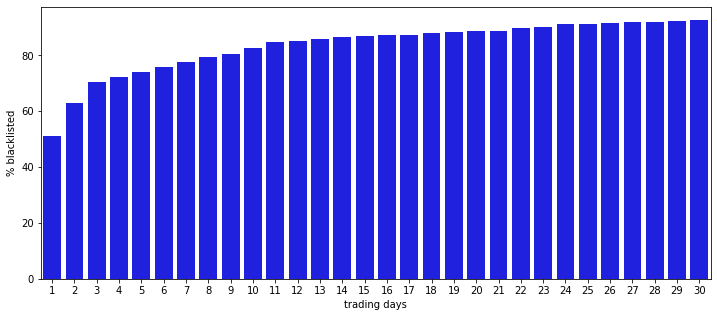

In [40]:
from matplotlib.pyplot import figure
figure(figsize=(12, 5))
sns.barplot(data= lists_by_day.iloc[0:30], y='% blacklisted', x='trading days', color='blue')

__155 trading days needed to capture 100% of blacklisted collections__

In [41]:
lists_by_day.iloc[150:160]

,trading days,# blacklisted,% blacklisted,# whitelisted,% whitelisted
150,151,274,99.6,645,89.6
151,152,274,99.6,645,89.6
152,153,274,99.6,645,89.6
153,154,274,99.6,646,89.7
154,155,275,100.0,646,89.7
155,156,275,100.0,647,89.9
156,157,275,100.0,648,90.0
157,158,275,100.0,648,90.0
158,159,275,100.0,648,90.0
159,160,275,100.0,648,90.0


__107 of the 1-day collections had only 1 trade total__

In [42]:
# Trade counts (volume) of collections with only 1 day of data
one_day_coll['volume'].value_counts()

1.0       107
2.0        34
3.0        21
4.0        18
5.0         8
7.0         6
12.0        4
11.0        4
10.0        4
8.0         4
6.0         3
3000.0      3
16.0        2
9.0         2
26.0        2
25.0        2
17.0        2
31.0        1
14.0        1
46.0        1
56.0        1
24.0        1
21.0        1
55.0        1
47.0        1
20.0        1
61.0        1
Name: volume, dtype: int64

__55/107 of these collections with only one trade are blacklisted__ 

In [43]:
one_day_coll[one_day_coll['blacklisted']=='1']['volume'].value_counts()

1.0     55
2.0     26
4.0     11
3.0     10
7.0      6
5.0      5
12.0     4
11.0     4
8.0      3
6.0      3
9.0      2
26.0     2
10.0     2
55.0     1
16.0     1
21.0     1
17.0     1
56.0     1
20.0     1
47.0     1
31.0     1
Name: volume, dtype: int64

In [44]:
# One collection with very high volume = weezer
#one_day_coll[one_day_coll['volume']==3354]

In [45]:
# many of these are fraudulent due to knock-off collections names
np.array(one_day_coll[one_day_coll['blacklisted']=='1']['collection'])

array(['1pokemenbolg', 'a11ianworlds', 'a1ieneworlds', 'a1ienlwor1ds',
       'a1ienoworlds', 'a1ienswor1ds', 'a1ienvvor1de', 'a1ienvvordds',
       'a1ienvvorlds', 'a1ienzworlds', 'aalienworlds', 'aallienworld',
       'aiiencworlds', 'aiienvvorlds', 'aiienworldss', 'aillenworlds',
       'ailllenworld', 'al1ienworl1d', 'ali1enworild', 'alieenworlds',
       'alieenworlld', 'aliemmworlds', 'aliemswworld', 'alieneworlds',
       'alienfworlds', 'aliengworlds', 'alienlworlds', 'aliennwiorld',
       'alienpaworld', 'aliensvvorld', 'alienswor1ds', 'aliensworldc',
       'aliensworlds', 'alienswworld', 'alienvvor1ds', 'alienvvorld2',
       'alienvvorlds', 'alienvvworld', 'alienwords23', 'alienworilds',
       'alienworldio', 'alienworrlds', 'alienwvorlds', 'alienwvvorld',
       'alienwworlld', 'alienxworlds', 'aliienworids', 'alleenworlds',
       'alleniworlds', 'allensworlbs', 'allenvvorlds', 'allienwulrds',
       'allienwurlds', 'alllenworlks', 'alllianworld', 'alonworldscs',
      

__Use full_dataset_1day to get the aggregated first day of trading for all collections__

This is the simplest dataset that includes all collections

In [46]:
# Move Datetime_updated_seconds from the index to its own column
full_dataset_1day = full_dataset_1day.reset_index()
full_dataset_1day.columns = full_dataset_1day.columns.str.replace('index', 'Datetime_updated_seconds')
full_dataset_1day

,Datetime_updated_seconds,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,collection,blacklisted,whitelisted
0,2020-12-02,0.040150,1.0000,1.000000,2.0,1.0,1.0,12345rainbow,1,0
1,2020-12-03,0.040150,1.0000,1.000000,2.0,1.0,0.0,12345rainbow,1,0
2,2020-12-04,0.036259,0.9900,0.333333,4.0,2.0,1.0,12345rainbow,1,0
3,2020-12-05,0.036259,0.9900,0.333333,4.0,2.0,0.0,12345rainbow,1,0
4,2021-03-31,0.131440,0.5025,0.666667,3.0,2.0,2.0,1amazingbook,0,1
...,...,...,...,...,...,...,...,...,...,...
40425,2021-03-30,1.642200,7.0000,0.047569,44.0,45.0,0.0,zombieartist,0,1
40426,2021-03-31,1.642200,7.0000,0.047569,44.0,45.0,0.0,zombieartist,0,1
40427,2021-04-01,1.642200,7.0000,0.047569,44.0,45.0,0.0,zombieartist,0,1
40428,2021-04-02,3.828750,15.0000,0.046465,45.0,46.0,1.0,zombieartist,0,1


In [48]:
# All collections and their first day of trading
first_days = full_dataset_1day.groupby('collection')['Datetime_updated_seconds'].min()

# Convert to dataframe to merge with full_dataset_1day
first_days_df = pd.DataFrame({'collection':first_days.keys(), 'Datetime_updated_seconds':first_days.values})
first_days_df.sort_values('Datetime_updated_seconds')

,collection,Datetime_updated_seconds
118,anyo.b1,2020-06-30
151,badges.b1,2020-07-01
854,stickypeople,2020-07-01
536,krwingerarts,2020-07-01
702,niftysticker,2020-07-01
...,...,...
219,catcartegwel,2021-04-27
59,aliengworlds,2021-04-27
945,virtualdream,2021-04-27
617,ml1libtoopps,2021-04-27


In [49]:
# Simplest data set: 995 rows summarizing the first day of trading for each collection
first_days_df1 = first_days_df.merge(full_dataset_1day, on=['collection','Datetime_updated_seconds'])
first_days_df1

,collection,Datetime_updated_seconds,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,blacklisted,whitelisted
0,12345rainbow,2020-12-02,0.040150,1.000000,1.000000,2.0,1.0,1.0,1,0
1,1amazingbook,2021-03-31,0.131440,0.502500,0.666667,3.0,2.0,2.0,0,1
2,1bitcoinlive,2021-04-09,125.450000,500.000000,1.000000,2.0,1.0,1.0,0,1
3,1bodyinmove1,2020-12-28,3.400800,80.000000,1.000000,2.0,1.0,1.0,0,1
4,1coolartnft1,2021-03-10,0.677100,3.000000,0.666667,3.0,2.0,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...
990,zeugencorona,2021-04-18,0.002080,0.009500,0.142857,8.0,4.0,4.0,1,0
991,zippergirls1,2020-11-11,15.701700,420.000000,1.000000,2.0,1.0,1.0,0,1
992,zlfhomedecor,2021-01-23,6.522222,152.777778,0.250000,8.0,7.0,9.0,0,1
993,zombaeseries,2021-03-23,7.579150,29.000000,1.000000,2.0,1.0,1.0,0,1


In [102]:
time_range = first_days_df1['Datetime_updated_seconds'].max() - first_days_df1['Datetime_updated_seconds'].min()
time_range.days

301

In [141]:
time_range = first_days_df1['Datetime_updated_seconds'].max() - first_days_df1['Datetime_updated_seconds'].min() #301 days
cutoff_date = first_days_df1['Datetime_updated_seconds'].min() + timedelta(days=1)

split_dates = pd.DataFrame(columns=['cutoff date', 'train %blacklisted', 'train size', 'test %blacklisted', 'test size'])
for i in range(1, time_range.days):
    train = first_days_df1[first_days_df1['Datetime_updated_seconds'] < cutoff_date]
    test = first_days_df1[first_days_df1['Datetime_updated_seconds'] >= cutoff_date]
    
    train_blist = train['blacklisted'].astype(int).sum()/train.shape[0]
    train_size = train.shape[0]/first_days_df1.shape[0]
    test_blist = test['blacklisted'].astype(int).sum()/test.shape[0]
    test_size = test.shape[0]/first_days_df1.shape[0]
    
    split_dates = split_dates.append({'cutoff date':cutoff_date, 'train %blacklisted':train_blist, 'train size':train_size, 
                                      'test %blacklisted':test_blist, 'test size':test_size}, ignore_index=True)
    cutoff_date = first_days_df1['Datetime_updated_seconds'].min() + timedelta(days=i)  

__Training/Test Splits by Cutoff Date with split ratios ranging from 60:40 to 90:10__

In [143]:
split_dates.iloc[288:]

,cutoff date,train %blacklisted,train size,test %blacklisted,test size
288,2021-04-14,0.205645,0.747739,0.486056,0.252261
289,2021-04-15,0.211921,0.758794,0.479167,0.241206
290,2021-04-16,0.219481,0.773869,0.471111,0.226131
291,2021-04-17,0.222930,0.788945,0.476190,0.211055
292,2021-04-18,0.227216,0.805025,0.479381,0.194975
293,2021-04-19,0.233577,0.826131,0.479769,0.173869
294,2021-04-20,0.243468,0.846231,0.457516,0.153769
295,2021-04-21,0.261364,0.884422,0.391304,0.115578
296,2021-04-22,0.266219,0.898492,0.366337,0.101508
297,2021-04-23,0.270925,0.912563,0.333333,0.087437


In [146]:
cutoff_date = '2021-04-22'
train = first_days_df1[first_days_df1['Datetime_updated_seconds'] < cutoff_date]
test = first_days_df1[first_days_df1['Datetime_updated_seconds'] >= cutoff_date]

In [154]:
train_90_10_split = train['collection']
#path = 'C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\train_90_10_split.csv'
#train_90_10_split.to_csv(path)

In [162]:
trn = pd.read_csv('C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\train_90_10_split.csv')
first_days_df1[first_days_df1['collection'].isin(trn['collection'])]

,collection,Datetime_updated_seconds,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,blacklisted,whitelisted,log_Price_USD,log_Price_Crypto,log_volume,log_vertex,log_edge
0,12345rainbow,2020-12-02,0.040150,1.000000,1.000000,2.0,1.0,1.0,1,0,-3.215133,0.000000,0.000000,0.693147,0.000000
1,1amazingbook,2021-03-31,0.131440,0.502500,0.666667,3.0,2.0,2.0,0,1,-2.029203,-0.688160,0.693147,1.098612,0.693147
2,1bitcoinlive,2021-04-09,125.450000,500.000000,1.000000,2.0,1.0,1.0,0,1,4.831907,6.214608,0.000000,0.693147,0.000000
3,1bodyinmove1,2020-12-28,3.400800,80.000000,1.000000,2.0,1.0,1.0,0,1,1.224011,4.382027,0.000000,0.693147,0.000000
4,1coolartnft1,2021-03-10,0.677100,3.000000,0.666667,3.0,2.0,2.0,0,1,-0.389936,1.098612,0.693147,1.098612,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,zeugencorona,2021-04-18,0.002080,0.009500,0.142857,8.0,4.0,4.0,1,0,-6.175147,-4.656463,1.386294,2.079442,1.386294
991,zippergirls1,2020-11-11,15.701700,420.000000,1.000000,2.0,1.0,1.0,0,1,2.753769,6.040255,0.000000,0.693147,0.000000
992,zlfhomedecor,2021-01-23,6.522222,152.777778,0.250000,8.0,7.0,9.0,0,1,1.875215,5.028984,2.197225,2.079442,1.945910
993,zombaeseries,2021-03-23,7.579150,29.000000,1.000000,2.0,1.0,1.0,0,1,2.025401,3.367296,0.000000,0.693147,0.000000


__A naive model (none blacklisted / all whitelisted) has a 72% accuracy__

In [50]:
first_days_df1['blacklisted'].value_counts(normalize=True)

0    0.723618
1    0.276382
Name: blacklisted, dtype: float64

In [51]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

__The other naive model (all blacklisted / none whitelisted) has a 27.6% Precision and 43% F1__

In [107]:
naive = np.zeros( (first_days_df1.shape[0],1) )
naive.fill(1)
y_score = naive
y_test = first_days_df1['blacklisted'].astype(int)
print("Naive Precision =", precision_score(y_test, y_score))
print("Naive Recall =", recall_score(y_test, y_score))
print("Naive F1 =", f1_score(y_test, y_score))
print("Naive PR AUC =", average_precision_score(y_test, y_score))

Naive Precision = 0.27638190954773867
Naive Recall = 1.0
Naive F1 = 0.43307086614173224
Naive PR AUC = 0.27638190954773867


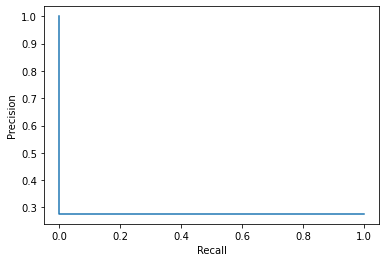

In [128]:
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [133]:
# Log Transforms for visualization of class separation
first_days_df1['log_Price_USD'] = np.log(first_days_df1['Price_USD'])
first_days_df1['log_Price_Crypto'] = np.log(first_days_df1['Price_Crypto'])
first_days_df1['log_volume'] = np.log(first_days_df1['volume'])
first_days_df1['log_vertex'] = np.log(first_days_df1['vertex_count'])
first_days_df1['log_edge'] = np.log(first_days_df1['edge_count'])

__Some visual separation between the classes with addition of network metrics.  Logistic regression would likely give a poor model.  SVM Kernel might be ok__

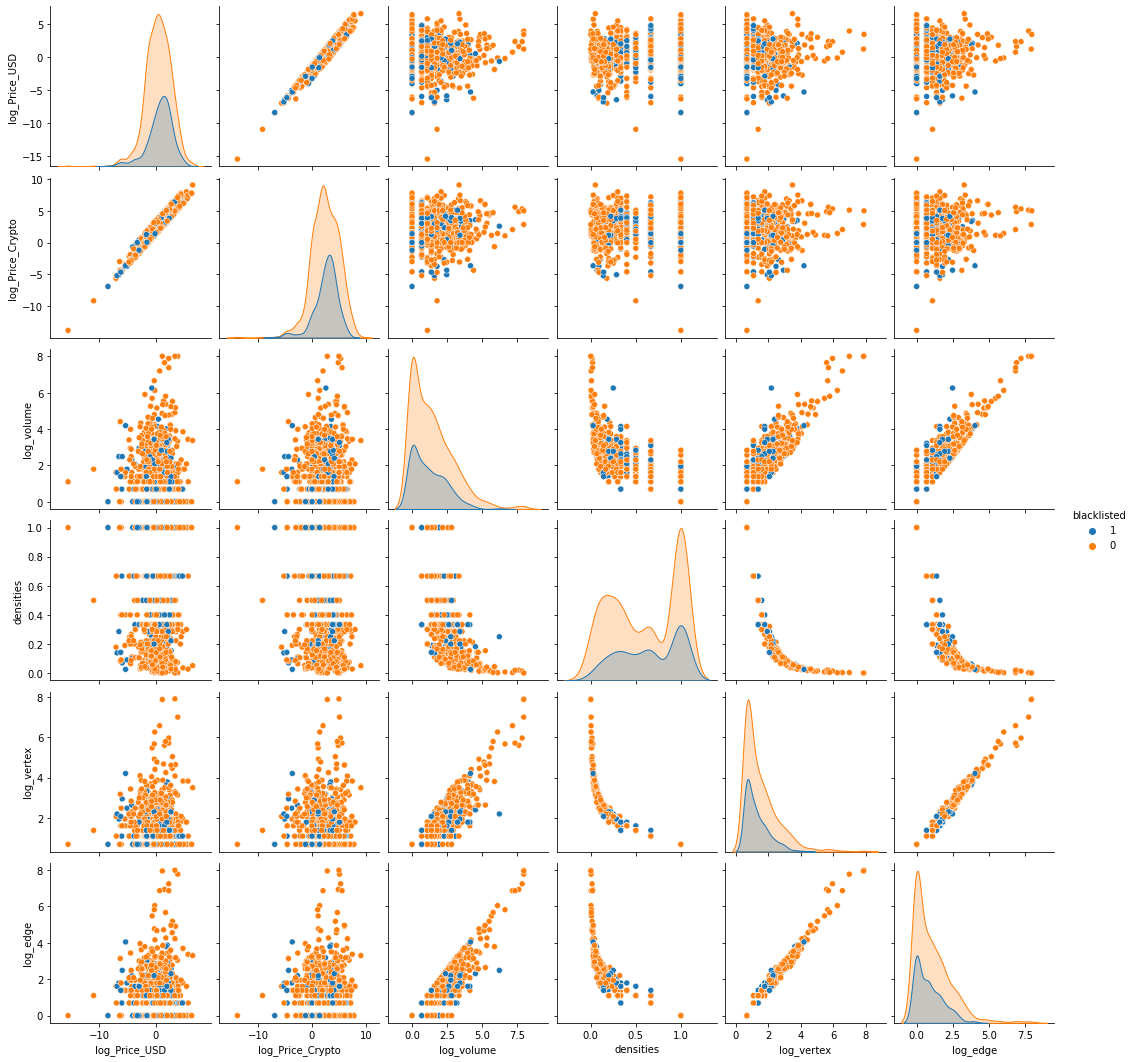

In [134]:
sns.pairplot(first_days_df1[['log_Price_USD', 'log_Price_Crypto','log_volume','blacklisted',
                            'densities','log_vertex','log_edge']], hue='blacklisted')

In [ ]:
day1_dataset_10min = None
for collection in network_ntrades_dfs:
    name = str(collection[0])
    collection_values = coll_train.loc[coll_train['collection']==name][['blacklist', 'whitelist']].values
    a_ts_collection = None
    if collection_values[0][0] == 1:
        a_ts_collection = convert_to_ts(collection[1], '10min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '1'
        a_ts_collection['whitelisted'] = '0'
    if collection_values[0][1] == 1:
        a_ts_collection = convert_to_ts(collection[1], '10min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '0'
        a_ts_collection['whitelisted'] = '1'
    
    # Only keep the first day (24 hours) of trades
    a_ts_collection = a_ts_collection.reset_index() # move 'Datetime_updated_seconds' from index to column
    a_ts_collection.columns = a_ts_collection.columns.str.replace('index', 'Datetime_updated_seconds')
    cutoff_date = a_ts_collection['Datetime_updated_seconds'].min() + timedelta(days=1)
    a_ts_collection = a_ts_collection[a_ts_collection['Datetime_updated_seconds'] < cutoff_date]
    
    if a_ts_collection is not None:
        if day1_dataset_10min is not None:
            day1_dataset_10min = pd.concat([day1_dataset_10min, a_ts_collection])
        else:
            day1_dataset_10min = a_ts_collection

In [ ]:
day1_dataset_10min

In [ ]:
# Check - Should be 144 (24*60/10) rows per collection
day1_dataset_10min.shape[0]/len(day1_dataset_10min['collection'].unique())

In [ ]:
'''day1_dataset_30min = None
for collection in network_ntrades_dfs:
    name = str(collection[0])
    collection_values = coll_train.loc[coll_train['collection']==name][['blacklist', 'whitelist']].values
    a_ts_collection = None
    if collection_values[0][0] == 1:
        a_ts_collection = convert_to_ts(collection[1], '30min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '1'
        a_ts_collection['whitelisted'] = '0'
    if collection_values[0][1] == 1:
        a_ts_collection = convert_to_ts(collection[1], '30min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '0'
        a_ts_collection['whitelisted'] = '1'
    
    # Only keep the first day (24 hours) of trades
    a_ts_collection = a_ts_collection.reset_index() # move 'Datetime_updated_seconds' from index to column
    a_ts_collection.columns = a_ts_collection.columns.str.replace('index', 'Datetime_updated_seconds')
    cutoff_date = a_ts_collection['Datetime_updated_seconds'].min() + timedelta(days=1)
    a_ts_collection = a_ts_collection[a_ts_collection['Datetime_updated_seconds'] < cutoff_date]
    
    if a_ts_collection is not None:
        if day1_dataset_30min is not None:
            day1_dataset_30min = pd.concat([day1_dataset_30min, a_ts_collection])
        else:
            day1_dataset_30min = a_ts_collection'''

In [ ]:
#day1_dataset_30min

In [ ]:
'''day1_dataset_60min = None
for collection in network_ntrades_dfs:
    name = str(collection[0])
    collection_values = coll_train.loc[coll_train['collection']==name][['blacklist', 'whitelist']].values
    a_ts_collection = None
    if collection_values[0][0] == 1:
        a_ts_collection = convert_to_ts(collection[1], '60min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '1'
        a_ts_collection['whitelisted'] = '0'
    if collection_values[0][1] == 1:
        a_ts_collection = convert_to_ts(collection[1], '60min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '0'
        a_ts_collection['whitelisted'] = '1'
    
    # Only keep the first day (24 hours) of trades
    a_ts_collection = a_ts_collection.reset_index() # move 'Datetime_updated_seconds' from index to column
    a_ts_collection.columns = a_ts_collection.columns.str.replace('index', 'Datetime_updated_seconds')
    cutoff_date = a_ts_collection['Datetime_updated_seconds'].min() + timedelta(days=1)
    a_ts_collection = a_ts_collection[a_ts_collection['Datetime_updated_seconds'] < cutoff_date]
    
    if a_ts_collection is not None:
        if day1_dataset_60min is not None:
            day1_dataset_60min = pd.concat([day1_dataset_60min, a_ts_collection])
        else:
            day1_dataset_60min = a_ts_collection'''

In [ ]:
#day1_dataset_60min

In [ ]:
'''day1_dataset_1min = None
for collection in network_ntrades_dfs:
    name = str(collection[0])
    collection_values = coll_train.loc[coll_train['collection']==name][['blacklist', 'whitelist']].values
    a_ts_collection = None
    if collection_values[0][0] == 1:
        a_ts_collection = convert_to_ts(collection[1], '1min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '1'
        a_ts_collection['whitelisted'] = '0'
    if collection_values[0][1] == 1:
        a_ts_collection = convert_to_ts(collection[1], '1min')
        a_ts_collection['collection'] = name
        a_ts_collection['blacklisted'] = '0'
        a_ts_collection['whitelisted'] = '1'
    
    # Only keep the first day (24 hours) of trades
    a_ts_collection = a_ts_collection.reset_index() # move 'Datetime_updated_seconds' from index to column
    a_ts_collection.columns = a_ts_collection.columns.str.replace('index', 'Datetime_updated_seconds')
    cutoff_date = a_ts_collection['Datetime_updated_seconds'].min() + timedelta(days=1)
    a_ts_collection = a_ts_collection[a_ts_collection['Datetime_updated_seconds'] < cutoff_date]
    
    if a_ts_collection is not None:
        if day1_dataset_1min is not None:
            day1_dataset_1min = pd.concat([day1_dataset_1min, a_ts_collection])
        else:
            day1_dataset_1min = a_ts_collection'''

In [ ]:
#day1_dataset_1min

In [ ]:
#path = 'C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\day1_dataset_1min_10Aug2022.csv'
#day1_dataset_1min.to_csv(path)

In [ ]:
#pd.read_csv('C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\day1_dataset_10min.csv')

In [ ]:
import plotly.express as px

In [ ]:
fig = px.line(day1_dataset_10min[day1_dataset_10min['blacklisted']=='0'], 
              x=day1_dataset_10min[day1_dataset_10min['blacklisted']=='0'].index, 
              y="edge_count", color='collection')
fig.show()

In [ ]:
fig = px.line(day1_dataset_10min[day1_dataset_10min['blacklisted']=='1'], 
              x=day1_dataset_10min[day1_dataset_10min['blacklisted']=='1'].index, 
              y="edge_count", color='collection')
fig.show()

In [ ]:
fig = px.line(day1_dataset_10min[(day1_dataset_10min['blacklisted']=='1')], 
              x=day1_dataset_10min[(day1_dataset_10min['blacklisted']=='1')].index, 
              y="Price_USD", color='collection')
fig.show()

In [ ]:
high_vol = ['mlb.topps', 'gdx.topps', 'gdz.topps', 'weezer']
fig = px.line(day1_dataset_10min[(day1_dataset_10min['blacklisted']=='0') &\
                                 (~day1_dataset_10min['collection'].isin(high_vol))], 
              x=day1_dataset_10min[(day1_dataset_10min['blacklisted']=='0') &\
                                 (~day1_dataset_10min['collection'].isin(high_vol))].index, 
              y="volume", color='collection')
fig.show()